### Import Packages

In [1]:
import os
import multiprocessing as mp
import random
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
sys.path.append('../dataset/')
import coco_api_helper
import coco_data_prep

loading annotations into memory...
Done (t=12.21s)
creating index...
index created!
loading annotations into memory...
Done (t=5.51s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


### Global Variables

In [4]:
train_np_data_dir = '../data/numpy_images/train/'

### Load Data

In [5]:
rand_100_files = np.random.choice(os.listdir(train_np_data_dir), 100)
filepaths_100 = [f"{train_np_data_dir}{fn}" for fn in rand_100_files]
filepaths_100[:5]

['../data/numpy_images/train/COCO_train2014_000000573241.np',
 '../data/numpy_images/train/COCO_train2014_000000443693.np',
 '../data/numpy_images/train/COCO_train2014_000000002400.np',
 '../data/numpy_images/train/COCO_train2014_000000231630.np',
 '../data/numpy_images/train/COCO_train2014_000000007221.np']

In [6]:
loaded_imgs = {}
for filepath in filepaths_100[:5]:
    img_name = filepath.split('/')[-1].split('.')[0]
    loaded_imgs[img_name] = np.load(filepath)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


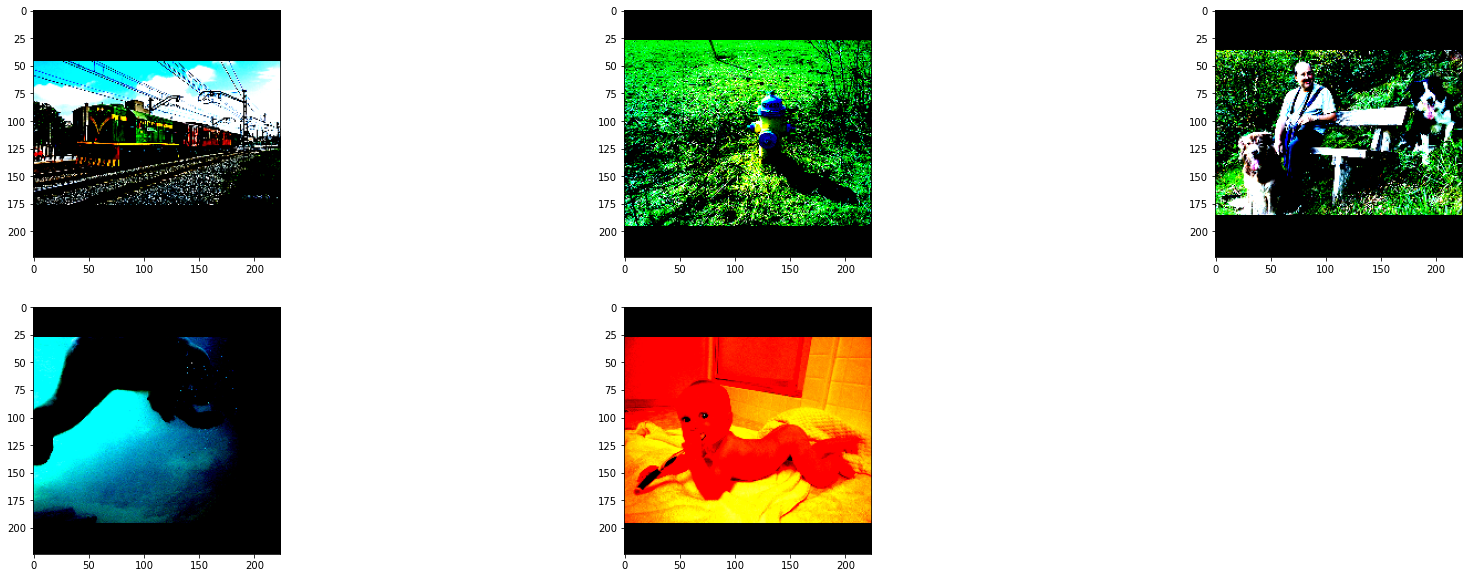

In [7]:
fig = plt.figure(1, figsize=(30, 10))
for i, (fn, np_img) in enumerate(loaded_imgs.items()):
    fig.add_subplot(2, 3, i+1)
    plt.imshow(np_img)
plt.show()

In [8]:
class COCODataset(Dataset):
    
    def __init__(self, data_dir: str, sample_ratio: int = None, randomize: bool = True):
        """
        :data_dir: data directory where images are stored (should be training or validation directory)
        :sample_ratio: if training, a % of the total training/validation data you wish to try your model on
            default is None, which means use all of the training or validation images in the specified data_dir
        :randomize: default is True
            when a sample_ratio is not None, the parameter to determine whether or not to just take top K images
            as the sample, OR to randomly select a subset of images from the data_dir
        """
        np.random.seed(42)
        self.data_dir = data_dir.rstrip('/')
        
        rand_file = np.random.choice(os.listdir(self.data_dir))
        filetype = rand_file.split('/')[-1].split('.')[-1]
        
        if filetype == 'np':
            self.filetype = 'binary'
        elif filetype == 'jpg' or filetype == 'jpeg':
            self.filetype = 'raw'
        else:
            raise ValueError("data_dir does not hold acceptable image file type, must be either `.np`, `.jpg`, or `.jpeg`")
            
        filepaths = [f"{self.data_dir}/{fn}" for fn in os.listdir(self.data_dir)]
    
        if self.filetype == 'binary':
            if sample_ratio is not None:
                num_imgs = int(sample_ratio * len(os.listdir(self.data_dir)))
                
                if randomize:
                    img_filepaths = np.random.choice(filepaths, num_imgs)
                else: 
                    img_filepaths = filepaths[:num_imgs]
                    
                self.dataset = [np.load(fp) for fp in tqdm(img_filepaths)]
            else:
                self.dataset = [np.load(fp) for fp in filepaths]
                
        elif self.filetype == 'jpg' or self.filetype == 'jpeg':
            num_cpus = mp.cpu_count()
            pool = mp.Pool(processes=num_cpus)
            print('Converting jpg images to np images')
            np_imgs = [pool.apply(jpg_image_to_np_array, args=([jpg_file])) for jpg_file in tqdm(os.listdir(self.data_dir))]
            print('Resizing and padding np images')
            resized = [pool.apply(resize_and_pad_img, args=([np_img])) for np_img in tqdm(np_images)]
            print('Normalizing images')
            normed = [pool.apply(normalize_img, args=([res])) for res in tqdm(resized)]
            pool.close()
            
        else: 
            raise ValueError('file type in data_dir must be np or jpg.')
        
    def __getitem__(self, index: int):
        return self.dataset[index]
    
    def __len__(self):
        return len(self.dataset)

### Initializing `COCODataset`
- `COCODataset` inherits from torch.utils.data.Dataset and requires a `__len__` and `__getitem__`.
- This is a map style [Dataset](https://pytorch.org/docs/stable/data.html#dataset-types).


- pass in the data directory (`data_dir`)
    - If the data directory is comprised of numpy files, then no transformations need be applied. **THIS ASSUMES** that these are the numpy files Sylvia made available in the s3 bucket: s3://cs7643-raml/ because those numpy files are already resized, padded, and normalized.
    - If the data directory is comprised of jpeg files, then transformations will be applied on them to resize, pad, and normalize the images and then save them as numpy files. This will take longer, but multiprocessing should be applied in order to ensure it will compute faster.
    
    
- pass in the `sample_ratio` argument
    - The sample ratio argument is to stipulate the % of the total images in the stipulated data directory that you wish to use for training your model. For example if there are a total of 80K+ images in the data directory, stipulating 5% will randomly select approximately 4K+ images from the data directory to write to the torch.utils.data.Dataset object (`COCODataset`)

In [9]:
train_dataset = COCODataset(train_np_data_dir, sample_ratio=0.05)

100%|█████████████████████████████████████████████| 4139/4139 [00:02<00:00, 1472.01it/s]


In [10]:
print(type(train_dataset))
print(type(train_dataset.dataset))

<class '__main__.COCODataset'>
<class 'list'>


### DataLoader
- when calling Dataloader, pass in your specific DataLoader arguments
    - `train_dataset` : `Dataset` object
    - `batch_size` : This is the stipulated batch size (lower this in the event you run into memory errors during training).
    - `shuffle = False` is a better DataLoader param if you stipulated a `sample_ratio` in the initialization of `COCODataset`.
    - `num_workers=mp.cpu_count()` is if you are running the process on the CPU instead of GPU otherwise stipulate number of GPUs. 

In [11]:
train_dl = DataLoader(dataset=train_dataset, 
                      batch_size=1000,
                      shuffle=False,
                      num_workers=mp.cpu_count())

In [12]:
print(type(train_dl))

<class 'torch.utils.data.dataloader.DataLoader'>


In [13]:
for i, img in enumerate(train_dl):
    print(i)
    print(img.shape)

0
torch.Size([1000, 224, 224, 3])
1
torch.Size([1000, 224, 224, 3])
2
torch.Size([1000, 224, 224, 3])
3
torch.Size([1000, 224, 224, 3])
4
torch.Size([139, 224, 224, 3])


### Accessing One Image at a Time
- because the `Dataset` object has the `__getitem__` method, you need only give the dataset object an index, to specify which image you'd like to inspect 

In [14]:
train_dataset[0]

array([[[-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        ...,
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444]],

       [[-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        ...,
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444]],

       [[-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        ...,
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444]],

       ...,

       [[-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -2.0357141, -1.8044444],
        [-2.117904 , -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


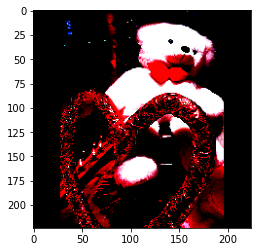

In [15]:
plt.imshow(train_dataset[0])